In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from transformers import AdamW
import pandas as pd
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import csv
import re
import validators
import emoji
import unidecode
import nltk
import pickle
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the seed for reproducibility
SEED = 1237
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# BERT Hyperparameters (ADDITION)
n_bert_layers = 16  # Assuming the base model has 12 layers
bert_lr = 0.001
pooling_strategy = 'cls'  # Options: 'cls', 'mean', 'max'
bert_hidden_size = 768  # Adjust based on your BERT model
max_seq_length = 128
fine_tune_strategy = 'full'  # Options: 'full', 'last_layer'
bert_dropout = 0.9  # Adjust based on BERT model specifications

max_seq_length = 128  # This should match the max_seq_length used in BERT model
padding_strategy = 'max_length'  # Options: 'max_length', 'do_not_pad', 'longest'
truncation_strategy = 'longest_first'  # Options: 'longest_first', 'only_first', 'only_second'
do_lower_case = False  # Set to False if using a cased model

config = BertConfig(
    num_hidden_layers=n_bert_layers,
    hidden_size=bert_hidden_size,
    num_attention_heads=24,  # Assuming 12 attention heads
    intermediate_size=4 * bert_hidden_size,  # Default value in BERT
    hidden_dropout_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', 
                                          max_length=max_seq_length,
                                          padding=padding_strategy,
                                          truncation=truncation_strategy,
                                          do_lower_case=do_lower_case)
# Load the BERT model with the custom configuration
bert_model = BertModel(config=config)

In [3]:
data_path = "multilabel-dataset.csv"  
data_df = pd.read_csv(data_path)
data_df = data_df.rename(columns={'Tweet Content': 'text', 'Sentiment': 'sentiment', 'Label': 'label'})

In [4]:
data_df

,text,sentiment,label
0,Dictator's son on the cusp of power in the #Ph...,Negative,Hate
1,Kung ang definition ni BongBong Marcos sa isan...,Negative,Hate
2,Leni Robredo is not being subjected by her opp...,Negative,Hate
3,@imstillsour Tuwang tuwa sila sa Pink hahaha.....,Negative,Hate
4,Kapag hindi si VP Leni Robredo ang iboboto mo ...,Negative,Hate
...,...,...,...
7675,VP LENI ROBREDO FOR 2022 https://t.co/2ahSefgmST,Neutral,Non-hate
7676,@alt_ego143 @rapplerdotcom @ramboreports hindi...,Neutral,Non-hate
7677,"I can't vote yet, but my president is Leni Rob...",Neutral,Non-hate
7678,Anyways President Leni Robredo #SaveLegendsOfT...,Neutral,Non-hate


In [5]:
# Preprocessing function
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:tokenizer.model_max_length - 2]  # Account for [CLS] and [SEP] tokens
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    return indexed_tokens

filipino_stopwords = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

# Date De-Identification
def remove_mentions(text):
    mention_pattern = re.compile(r'@\w+')
    
    # Use re.sub to remove mentions
    cleaned_text = mention_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# URL Removal
def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Use re.sub to remove URLs
    cleaned_text = url_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# Special Characters Removal
def remove_special_characters(text):
    text = emoji.replace_emoji(text, replace="[emoji]")
    
    # Split the text into words
    words = text.split(" ")
    
    # Initialize an empty string to store the cleaned text
    cleaned_text = ""
    
    # Iterate through each word
    for word in words:
        # Check if the word contains only special characters or "[emoji]"
        if not (re.match(r"^[_\W]+$", word) or "[emoji]" in word):
            if len(cleaned_text) == 0:
                cleaned_text = f"{word}"
            else:
                cleaned_text = f"{cleaned_text} {word}"
                
    # Remove diacritics
    text_no_diacritics = unidecode.unidecode(cleaned_text)

    # Split the text into words
    sentence = text_no_diacritics.split(" ")
    output = ""

    # Remove special characters and numerics
    for part in sentence:
        part = re.sub("[^A-Za-z ]+$", "", part)
        part = re.sub("^[^A-Za-z #]+", "", part)
        if not (len(part) <= 1 or re.match(r"[^a-zA-Z#]", part)):
            if len(output) == 0:
                output = f"{part}"
            else:
                output = f"{output} {part}"

    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(output.split())

    return cleaned_text

# Remove English Stop Words
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

# Remove English Stop Words
def remove_english_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text

# Remove Filipino Stop Words
def remove_filipino_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in filipino_stopwords]
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(filtered_words)
  
    return cleaned_text

# Candidate Name Removal
def remove_candidate_names(text):
    candidatelist = "leni robredo bongbong marcos isko moreno domagoso manny pacman pacquiao ping lacson ernie abella leody de guzman norberto gonzales jose montemayor jr faisal mangondato"
    candidatelist = candidatelist.split()
    candidate_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, candidatelist)) + r')\b', re.IGNORECASE)
    
    # Use re.sub to remove candidate names
    cleaned_text = candidate_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())
        
    return cleaned_text

# Hashtag Removal
def remove_hashtags(text):
    # Split the text into words
    words = text.split()
    
    # Initialize an empty list to store cleaned words
    cleaned_words = []
    
    for word in words:
        # Check if the word is a hashtag (starts with #)
        if not word.startswith('#'):
            cleaned_words.append(word)
    
    # Join the cleaned words into a single string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

In [6]:
for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos
https://t.co/5wbFYVWlG4 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista.

EJK sa Drug War at Martial Law mismo ang ebidensya.

#ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... https://t.co/hzn3LiQ5uJ 

Sentiment:  Negative 

-------------------------------------------------

Text:  @imstillsour Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila l

In [7]:
#PreProcessing

In [8]:
# Data De-Identification
data_df['text'] = data_df['text'].apply(remove_mentions)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos https://t.co/5wbFYVWlG4 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista. EJK sa Drug War at Martial Law mismo ang ebidensya. #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... https://t.co/hzn3LiQ5uJ 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink 

In [9]:
# URL Removal
data_df['text'] = data_df['text'].apply(remove_url)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista. EJK sa Drug War at Martial Law mismo ang ebidensya. #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink hahaha😅😂😂 

Sentiment:  Negative 

-------------

In [10]:
# Special Characters Removal
data_df['text'] = data_df['text'].apply(remove_special_characters)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit nanunupil ng civilian teenager na NON COMBATANT pinapatunayan lang na ang PNP-AFP ay terorista EJK sa Drug War at Martial Law mismo ang ebidensya #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question we do not want puppet president 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink 

Sentiment:  Negative 

-------------------------------------

In [11]:
# Lowercase
data_df['text'] = data_df['text'].str.lower()

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  dictator's son on the cusp of power in the #philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  kung ang definition ni bongbong marcos sa isang terorista ay isang armadong grupo na nananakit nanunupil ng civilian teenager na non combatant pinapatunayan lang na ang pnp-afp ay terorista ejk sa drug war at martial law mismo ang ebidensya #manggagawavsmagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  leni robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question we do not want puppet president 

Sentiment:  Negative 

-------------------------------------------------

Text:  tuwang tuwa sila sa pink hahaha..hindi nila alam pink color is sign for bongbong marcos..kasi favorite nya isuot pink...ambilis ni leni mag grab ng color kasi nakita nila langit nag pink 

Sentiment:  Negative 

-------------------------------------

In [12]:
# Retain Hashtags
#data_df['text'] = data_df['text'].apply(remove_hashtags)

#for i in range(10):
#    text = data_df["text"][i]
#    sentiment = data_df["sentiment"][i]

#    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

In [13]:
data_df.to_csv('pmulti-HT9010.csv', index=False)

In [14]:
data_df

,text,sentiment,label
0,dictator's son on the cusp of power in the #ph...,Negative,Hate
1,kung ang definition ni bongbong marcos sa isan...,Negative,Hate
2,leni robredo is not being subjected by her opp...,Negative,Hate
3,tuwang tuwa sila sa pink hahaha..hindi nila al...,Negative,Hate
4,kapag hindi si vp leni robredo ang iboboto mo ...,Negative,Hate
...,...,...,...
7675,vp leni robredo for,Neutral,Non-hate
7676,hindi pangngumbinse ang tawag dyan what he is ...,Neutral,Non-hate
7677,can't vote yet but my president is leni robred...,Neutral,Non-hate
7678,anyways president leni robredo #savelegendsoft...,Neutral,Non-hate


In [15]:
data_df['text'] = data_df['text'].apply(preprocess_text)

In [16]:
data_df.to_csv('pmulti-tokenized-HT9010.csv', index=False)

In [17]:
data_df

,text,sentiment,label
0,"[26400, 112, 188, 1488, 1113, 1103, 16408, 200...",Negative,Hate
1,"[180, 4380, 1126, 1403, 5754, 11437, 171, 4553...",Negative,Hate
2,"[5837, 2605, 187, 12809, 20792, 1110, 1136, 12...",Negative,Hate
3,"[189, 1358, 15946, 189, 1358, 3624, 27466, 174...",Negative,Hate
4,"[24181, 4163, 1403, 24856, 1182, 27466, 191, 1...",Negative,Hate
...,...,...,...
7675,"[191, 1643, 5837, 2605, 187, 12809, 20792, 1111]",Neutral,Non-hate
7676,"[24856, 1182, 13316, 17653, 19524, 7939, 2217,...",Neutral,Non-hate
7677,"[1169, 112, 189, 2992, 1870, 1133, 1139, 2084,...",Neutral,Non-hate
7678,"[4050, 1116, 2084, 5837, 2605, 187, 12809, 207...",Neutral,Non-hate


In [18]:
train_df, test_df = train_test_split(data_df, test_size=0.1, random_state=SEED)

In [19]:
### changed output_dim=3, added torch.softmax

In [20]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout) 
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=2, padding='same')
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=4, padding='same')
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        x = embedded.permute(0, 2, 1)  # Change the dimensions for convolution
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.global_pooling(x).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [21]:
# Set up iterators
BATCH_SIZE = 64

In [22]:
### changed "label" to "sentiment"

In [23]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_seq_length):
        self.data = dataframe
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']

        # Padding and conversion to tensor
        padded_text = torch.tensor(text[:self.max_seq_length] + [0] * (self.max_seq_length - len(text)))
        return padded_text, sentiment

In [24]:
train_dataset = TextDataset(train_df, 1000)
test_dataset = TextDataset(test_df, 1000)

In [25]:
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
# Define model hyperparameters
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 768
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 3
DROPOUT = 0.5

# CNN Hyperparameters
hidden_dim = 100
n_conv_layers = 1
kernel_sizes = [2, 3, 4]
activation = nn.ReLU()

In [27]:
# Initialize CNN model
model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [28]:
# Initialize BERT model (for embedding extraction)
bert_model.eval()  # Set to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.9, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-15): 16 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.9, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.9, inplace=False)
  

In [29]:
with torch.no_grad():
    for i, token in enumerate(tokenizer.get_vocab()):
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_embedding = bert_model.embeddings.word_embeddings.weight[token_id]
        model.embedding.weight[i].data.copy_(token_embedding)

bert_parameters = []
for layer in bert_model.encoder.layer:
    bert_parameters.extend(layer.parameters())

# Create AdamW optimizer with custom hyperparameters for BERT embeddings
bert_learning_rate = 2e-4  # Adjust as needed
bert_optimizer = optim.AdamW(bert_parameters, lr=bert_learning_rate)

In [30]:
#optimizer = optim.Adam(model.parameters())
# Your custom hyperparameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
weight_decay = 0.0

# Create Adam optimizer with custom hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [31]:
# Create a dictionary to map class labels to numerical indices
label_to_index = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

# Train function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, iterator):
    model.train()
    epoch_loss = 0
    for text_batch, sentiment_batch in iterator:
        # Extract text sequences from the text_batch tensor
        texts = text_batch
        
        # Use numerical labels for multi-class classification
        labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)

        texts = texts.to(device)  # Move to device if needed
        
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Evaluate function
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    predicted_sentiments = []
    true_sentiments = []  # Declare the true_sentiments list
    
    with torch.no_grad():
        for text_batch, sentiment_batch in iterator:
            texts = text_batch  # Extract text sequences
            
            # Use numerical labels
            labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)
            
            texts = texts.to(device)  # Move to device
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            # Convert predictions to class labels
            predicted_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in torch.argmax(predictions, dim=1).cpu().numpy()])
            true_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in labels.cpu().numpy()])
    
    # Calculate accuracy, f1, precision, recall
    accuracy = accuracy_score(true_sentiments, predicted_sentiments)
    f1 = f1_score(true_sentiments, predicted_sentiments, average='macro')
    precision = precision_score(true_sentiments, predicted_sentiments, average='macro')
    recall = recall_score(true_sentiments, predicted_sentiments, average='macro')
    
    return epoch_loss / len(iterator), accuracy, f1, precision, recall, predicted_sentiments, true_sentiments

D:\Users\Mai\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 01

	Train Loss: 1.022
	Test Loss: 0.961

	Accuracy: 0.5573 | F1-Score: 0.4565
	Precision: 0.4913 | Recall: 0.5484

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.5724    0.8669    0.6896       278
    Negative     0.3529    0.0240    0.0449       250
     Neutral     0.5485    0.7542    0.6351       240

    accuracy                         0.5573       768
   macro avg     0.4913    0.5484    0.4565       768
weighted avg     0.4935    0.5573    0.4627       768


[[241   5  32]
 [127   6 117]
 [ 53   6 181]]


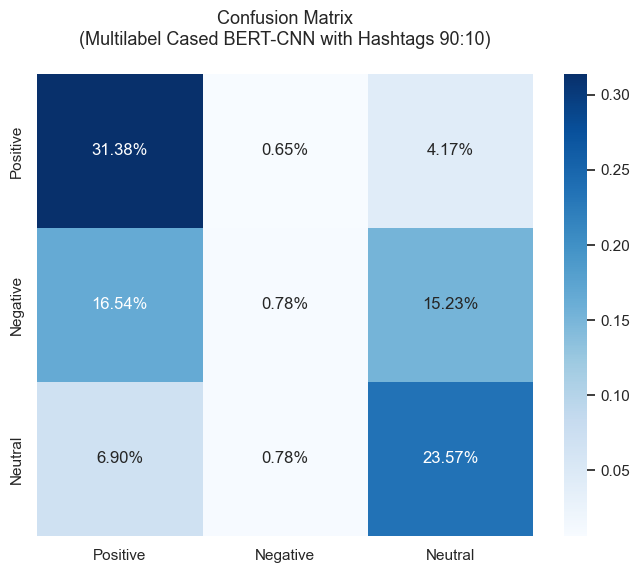

Epoch: 02

	Train Loss: 0.934
	Test Loss: 0.933

	Accuracy: 0.6016 | F1-Score: 0.5864
	Precision: 0.5945 | Recall: 0.5933

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6264    0.8201    0.7103       278
    Negative     0.4577    0.3680    0.4080       250
     Neutral     0.6995    0.5917    0.6411       240

    accuracy                         0.6016       768
   macro avg     0.5945    0.5933    0.5864       768
weighted avg     0.5943    0.6016    0.5903       768


[[228  45   5]
 [102  92  56]
 [ 34  64 142]]


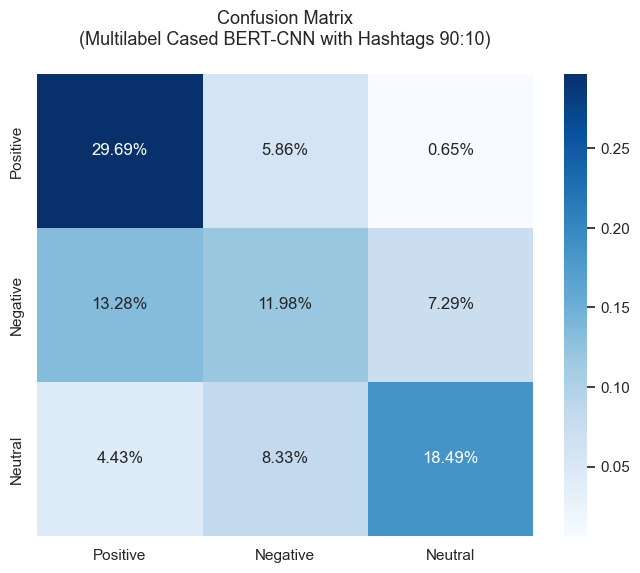

Epoch: 03

	Train Loss: 0.883
	Test Loss: 0.895

	Accuracy: 0.6406 | F1-Score: 0.6381
	Precision: 0.6388 | Recall: 0.6386

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7683    0.7158    0.7412       278
    Negative     0.5020    0.5000    0.5010       250
     Neutral     0.6462    0.7000    0.6720       240

    accuracy                         0.6406       768
   macro avg     0.6388    0.6386    0.6381       768
weighted avg     0.6435    0.6406    0.6414       768


[[199  63  16]
 [ 49 125  76]
 [ 11  61 168]]


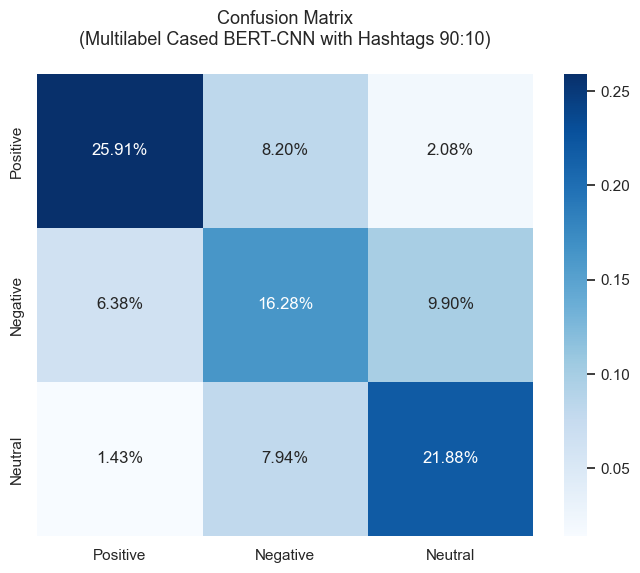

Epoch: 04

	Train Loss: 0.831
	Test Loss: 0.873

	Accuracy: 0.6628 | F1-Score: 0.6611
	Precision: 0.6694 | Recall: 0.6581

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7607    0.7662    0.7634       278
    Negative     0.5261    0.6040    0.5624       250
     Neutral     0.7214    0.6042    0.6576       240

    accuracy                         0.6628       768
   macro avg     0.6694    0.6581    0.6611       768
weighted avg     0.6721    0.6628    0.6649       768


[[213  56   9]
 [ 52 151  47]
 [ 15  80 145]]


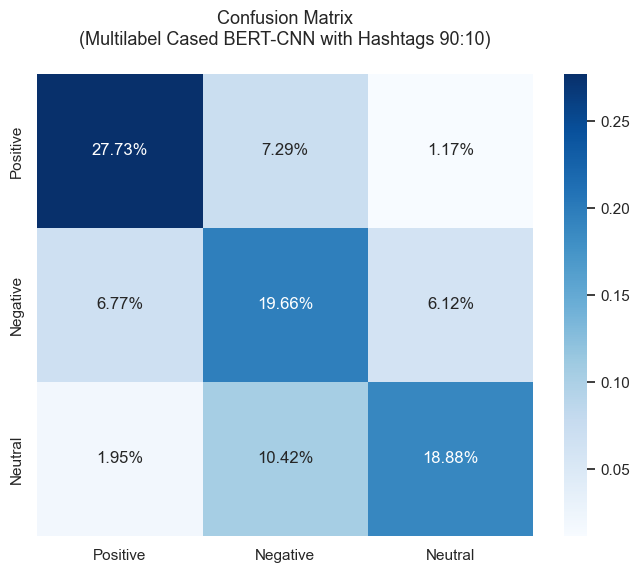

Epoch: 05

	Train Loss: 0.794
	Test Loss: 0.860

	Accuracy: 0.6719 | F1-Score: 0.6624
	Precision: 0.6629 | Recall: 0.6677

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7825    0.8022    0.7922       278
    Negative     0.5805    0.4760    0.5231       250
     Neutral     0.6259    0.7250    0.6718       240

    accuracy                         0.6719       768
   macro avg     0.6629    0.6677    0.6624       768
weighted avg     0.6678    0.6719    0.6670       768


[[223  32  23]
 [ 50 119  81]
 [ 12  54 174]]


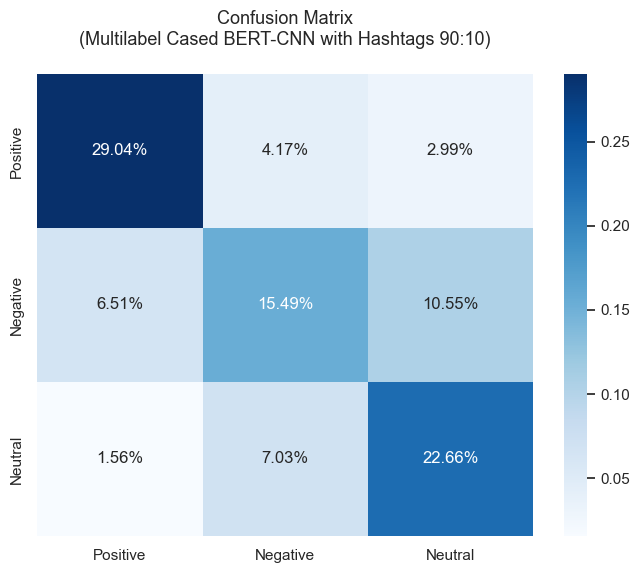

Epoch: 06

	Train Loss: 0.773
	Test Loss: 0.850

	Accuracy: 0.6823 | F1-Score: 0.6781
	Precision: 0.6813 | Recall: 0.6772

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7629    0.7986    0.7803       278
    Negative     0.5736    0.6080    0.5903       250
     Neutral     0.7075    0.6250    0.6637       240

    accuracy                         0.6823       768
   macro avg     0.6813    0.6772    0.6781       768
weighted avg     0.6840    0.6823    0.6820       768


[[222  43  13]
 [ 49 152  49]
 [ 20  70 150]]


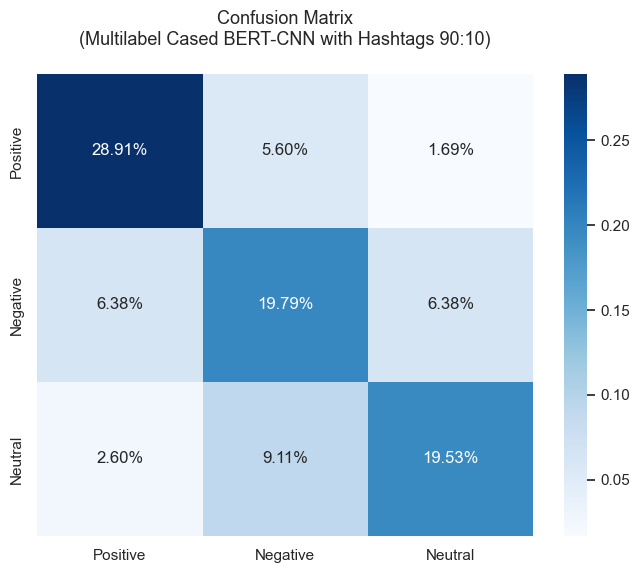

Epoch: 07

	Train Loss: 0.752
	Test Loss: 0.846

	Accuracy: 0.6966 | F1-Score: 0.6943
	Precision: 0.6959 | Recall: 0.6932

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7920    0.7806    0.7862       278
    Negative     0.5871    0.6200    0.6031       250
     Neutral     0.7087    0.6792    0.6936       240

    accuracy                         0.6966       768
   macro avg     0.6959    0.6932    0.6943       768
weighted avg     0.6993    0.6966    0.6977       768


[[217  50  11]
 [ 39 155  56]
 [ 18  59 163]]


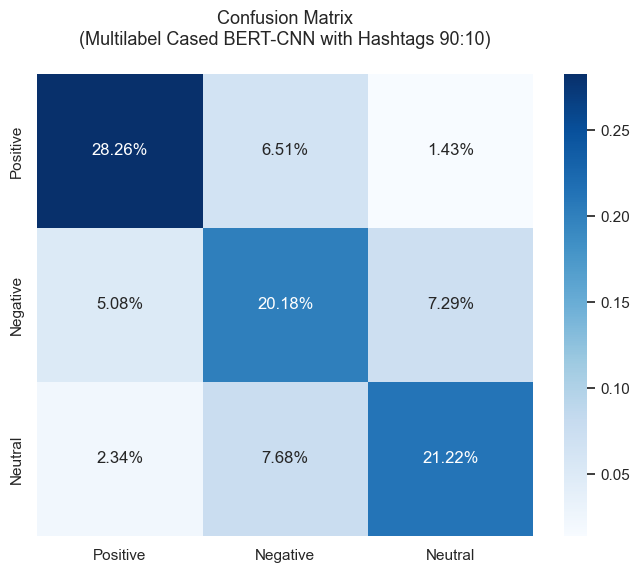

Epoch: 08

	Train Loss: 0.736
	Test Loss: 0.850

	Accuracy: 0.6927 | F1-Score: 0.6848
	Precision: 0.6868 | Recall: 0.6863

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7460    0.8453    0.7926       278
    Negative     0.6111    0.5720    0.5909       250
     Neutral     0.7032    0.6417    0.6710       240

    accuracy                         0.6927       768
   macro avg     0.6868    0.6863    0.6848       768
weighted avg     0.6887    0.6927    0.6889       768


[[235  30  13]
 [ 55 143  52]
 [ 25  61 154]]


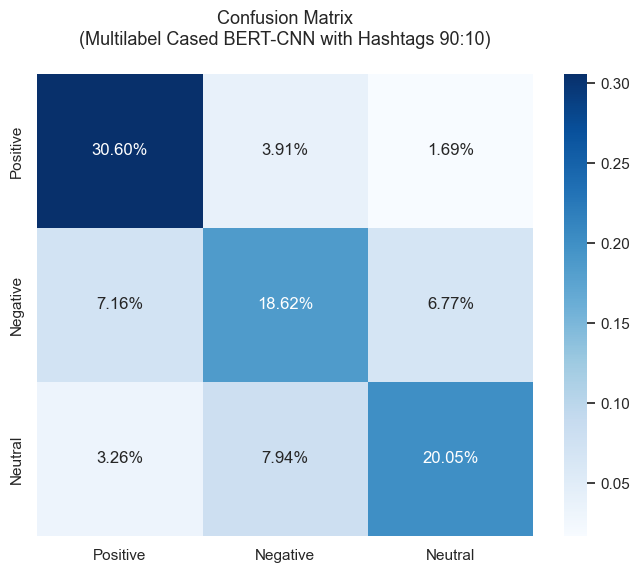

Epoch: 09

	Train Loss: 0.731
	Test Loss: 0.848

	Accuracy: 0.6927 | F1-Score: 0.6815
	Precision: 0.6826 | Recall: 0.6865

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7611    0.8597    0.8074       278
    Negative     0.6225    0.5080    0.5595       250
     Neutral     0.6640    0.6917    0.6776       240

    accuracy                         0.6927       768
   macro avg     0.6826    0.6865    0.6815       768
weighted avg     0.6857    0.6927    0.6861       768


[[239  21  18]
 [ 57 127  66]
 [ 18  56 166]]


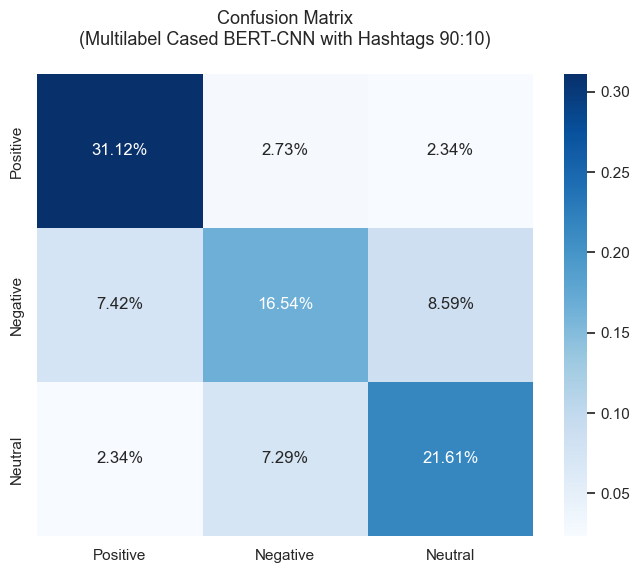

Epoch: 10

	Train Loss: 0.719
	Test Loss: 0.849

	Accuracy: 0.6966 | F1-Score: 0.6934
	Precision: 0.6942 | Recall: 0.6928

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.8148    0.7914    0.8029       278
    Negative     0.5914    0.6080    0.5996       250
     Neutral     0.6763    0.6792    0.6778       240

    accuracy                         0.6966       768
   macro avg     0.6942    0.6928    0.6934       768
weighted avg     0.6988    0.6966    0.6976       768


[[220  39  19]
 [ 39 152  59]
 [ 11  66 163]]


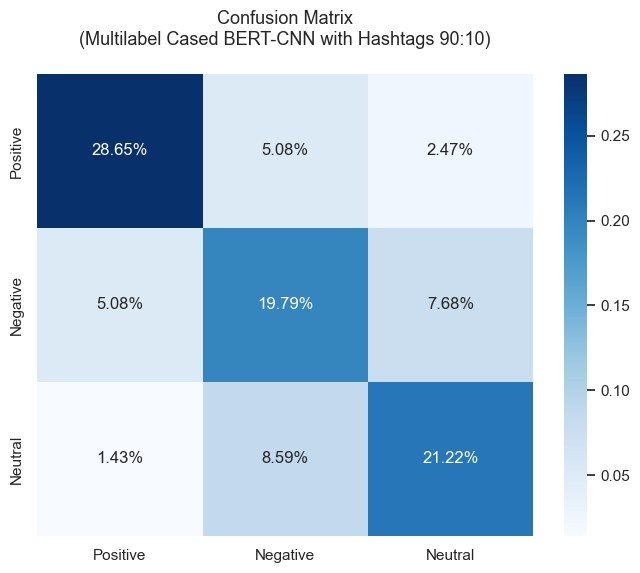

In [32]:
from sklearn.metrics import classification_report

N_EPOCHS = 10
predicted_sentiments_per_epoch = []
true_sentiments_per_epoch = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator)
    test_loss, accuracy, f1, precision, recall, predicted_sentiments, true_sentiments = evaluate(model, test_iterator)
    
    # Save the predicted_sentiments and true_sentiments for the current epoch
    predicted_sentiments_per_epoch.append(predicted_sentiments)
    true_sentiments_per_epoch.append(true_sentiments)

    # Print other metrics (e.g., accuracy, loss) for the current epoch
    print(f'Epoch: {epoch + 1:02}\n')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest Loss: {test_loss:.3f}\n')
    print(f'\tAccuracy: {accuracy:.4f} | F1-Score: {f1:.4f}')
    print(f'\tPrecision: {precision:.4f} | Recall: {recall:.4f}\n')
    print(f'\tClassification Report:\n')
    report = classification_report(true_sentiments, predicted_sentiments, target_names=['Positive', 'Negative', 'Neutral'], digits = 4)
    print(f'{report}\n')
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np  # Import numpy for matrix normalization

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(true_sentiments, predicted_sentiments)
    print(cf_matrix)

    # Plot the confusion matrix using seaborn
    sns.set(rc={"figure.figsize": (8, 6)})  # Add a closing parenthesis to set
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'], fmt='.2%', cmap='Blues')

    plt.title('Confusion Matrix\n(Multilabel Cased BERT-CNN with Hashtags 90:10)\n', fontsize=13)
    plt.show()